# Movie recommender systems using Regularized movie and user effect model


____________________________________________________________________

A recommender system is a type of information filtering system that predicts the preference or rating a user might give to an item (such as movies, music, products, or content). The primary goal of these systems is to deliver relevant items to users, enhancing user satisfaction by guiding them through the vast array of available options.

### Classification of Recommender System Approaches



**Collaborative Filtering**: This approach leverages user interactions and historical data (such as ratings or watch history) to make recommendations. It is based on the assumption that users who agreed in the past will agree in the future. Collaborative filtering is divided into:

- User-Based Collaborative Filtering: Recommends items that similar users have liked.

- Item-Based Collaborative Filtering: Recommends items similar to the ones the user has liked in the past.

**Content-Based Filtering**: This approach focuses on the features of items and matches them to the user’s profile, which includes preferences or past interactions. The system recommends items similar to those the user has previously shown interest in, based on item attributes.

**Hybrid Methods**: These systems combine collaborative and content-based methods to improve accuracy and cover limitations of individual methods, aiming to benefit from the strengths of both.



Let's import the necessary libraries:

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

## I-Loading of data 

We will import first the movielens data, whish is available at the website : http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [5]:
Data_stats=pd.read_csv('ml-100k/u.info',header=None)

A first glance on the data size 

In [6]:
Data_stats[0]

0         943 users
1        1682 items
2    100000 ratings
Name: 0, dtype: object

### 1-Loading of rating data

Now let's import the full data set with 100000 ratings by 943 users on 1682 items.

In [7]:
Columns=['User id','movie id','Rating','Timestamp']
u_Data=pd.read_csv('ml-100k/u.data', header=None, sep='\t', names=Columns )

In [8]:
u_Data.head()

,User id,movie id,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Let's check Nan values if they exist 

In [9]:
u_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   User id    100000 non-null  int64
 1   movie id   100000 non-null  int64
 2   Rating     100000 non-null  int64
 3   Timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


As seen above, the data is complete and it has no  missing values. let's check if we have duplicated rows :

In [10]:
print(u_Data.duplicated().sum())


0


In [11]:
u_Data.head()

,User id,movie id,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The time stamps are unix seconds since 1/1/1970 UTC ; this column is written in incomprehnsible format , so let's change it to a more readable one

In [12]:
# Convert timestamp to datetime
u_Data['date'] = pd.to_datetime(u_Data['Timestamp'], unit='s')


In [13]:
u_Data

,User id,movie id,Rating,Timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16
...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22 05:10:44
99996,716,204,5,879795543,1997-11-17 19:39:03
99997,276,1090,1,874795795,1997-09-20 22:49:55
99998,13,225,2,882399156,1997-12-17 22:52:36


In [14]:
u_Data.drop('Timestamp', axis=1)

,User id,movie id,Rating,date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03
99997,276,1090,1,1997-09-20 22:49:55
99998,13,225,2,1997-12-17 22:52:36


### 2- Loading of Movies data 

Now let's load the movies data (u.item), it has informations about different movies

In [15]:
Movies_ids=['movie id', 'movie title','release date',' video releasedate','IMDb URL' ,'unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
u_item = pd.read_csv('ml-100k/u.item', header=None, sep='|', names=Movies_ids, encoding='ISO-8859-1')

In [16]:
u_item


,movie id,movie title,release date,video releasedate,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
u_item.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie id            1682 non-null   int64  
 1   movie title         1682 non-null   object 
 2   release date        1681 non-null   object 
 3    video releasedate  0 non-null      float64
 4   IMDb URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

We notice that the video realease date column is all null , so we decide to drop this column

In [18]:
u_item.drop(' video releasedate', axis=1)


,movie id,movie title,release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
movies_names=u_item[['movie id','movie title']]


In [20]:
movies_names

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


### 3- Loading of user's data 

In [21]:
user_col=['user id','age','gender','occupation','zip code']
u_user = pd.read_csv('ml-100k/u.user', header=None, sep='|', names=user_col, encoding='ISO-8859-1')

In [22]:
u_user

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


Do all Do all the users appear in the u.data file?

In [61]:
# Check if all users from u.user appear in u.data
all_users_in_data = set(u_user['user id'])  # From user data
users_in_u_data = set(u_Data['User id'])       # From ratings data

# Find missing users
missing_users = all_users_in_data - users_in_u_data

# Output results
print(f"Total users in u.user: {len(all_users_in_data)}")
print(f"Total users in u.data: {len(users_in_u_data)}")
print(f"Missing users: {len(missing_users)}")
print("Missing User IDs:", missing_users)


Total users in u.user: 943
Total users in u.data: 943
Missing users: 0
Missing User IDs: set()


Do all the movies appear in the u.data file?

In [62]:
# Check if all movies from u.item appear in u.data
all_movies_in_item = set(u_item['movie id'])  # From movies data
movies_in_u_data = set(u_Data['movie id'])         # From ratings data

# Find missing movies
missing_movies = all_movies_in_item - movies_in_u_data

# Output results
print(f"Total movies in u.item: {len(all_movies_in_item)}")
print(f"Total movies in u.data: {len(movies_in_u_data)}")
print(f"Missing movies: {len(missing_movies)}")
print("Missing Movie IDs:", missing_movies)


Total movies in u.item: 1682
Total movies in u.data: 1682
Missing movies: 0
Missing Movie IDs: set()


So the data is complete  and we can merge  the different datasets successfully without losing any data

## II-Data visualization and EDA

### 1-Rating distrubition

First of all , we are going to explore the   rating distrubution for each rate between 0-5 



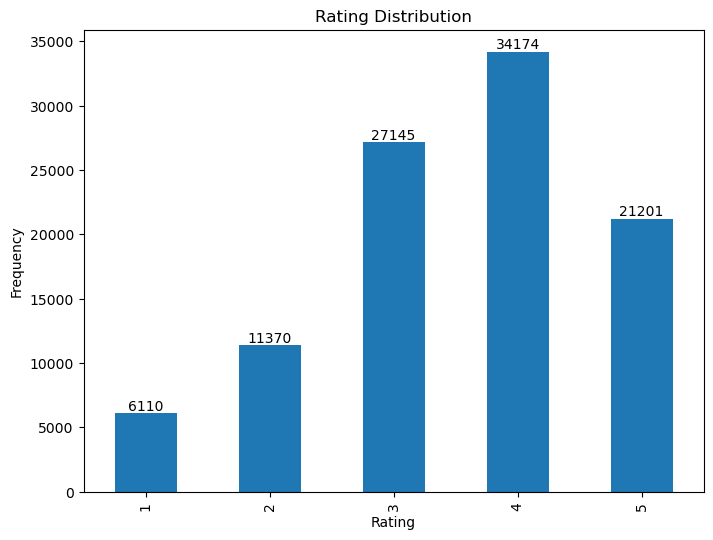

In [23]:


# Count how many users give each rating
rating_counts = u_Data['Rating'].value_counts().sort_index()

# Plot the distribution of ratings
ax = rating_counts.plot(kind='bar', title='Rating Distribution', figsize=(8, 6))
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Annotate each bar with the count
for i, count in enumerate(rating_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()



This shows how common each rating level is across all users adn items.


Now let's adress the popularity of  each movie, by displaying  ratings for each movie, but before doing this , a nice idea may be adding movie titles to the u_data this can be done by merging the u data and u item dataframes :

In [24]:
merged_dataset = pd.merge(u_Data, movies_names, how='inner', on='movie id')

In [25]:
merged_dataset

,User id,movie id,Rating,Timestamp,date,movie title
0,196,242,3,881250949,1997-12-04 15:55:49,Kolya (1996)
1,186,302,3,891717742,1998-04-04 19:22:22,L.A. Confidential (1997)
2,22,377,1,878887116,1997-11-07 07:18:36,Heavyweights (1994)
3,244,51,2,880606923,1997-11-27 05:02:03,Legends of the Fall (1994)
4,166,346,1,886397596,1998-02-02 05:33:16,Jackie Brown (1997)
...,...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22 05:10:44,"First Wives Club, The (1996)"
99996,716,204,5,879795543,1997-11-17 19:39:03,Back to the Future (1985)
99997,276,1090,1,874795795,1997-09-20 22:49:55,Sliver (1993)
99998,13,225,2,882399156,1997-12-17 22:52:36,101 Dalmatians (1996)


In [26]:
merged_dataset.drop('Timestamp', axis=1)

,User id,movie id,Rating,date,movie title
0,196,242,3,1997-12-04 15:55:49,Kolya (1996)
1,186,302,3,1998-04-04 19:22:22,L.A. Confidential (1997)
2,22,377,1,1997-11-07 07:18:36,Heavyweights (1994)
3,244,51,2,1997-11-27 05:02:03,Legends of the Fall (1994)
4,166,346,1,1998-02-02 05:33:16,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44,"First Wives Club, The (1996)"
99996,716,204,5,1997-11-17 19:39:03,Back to the Future (1985)
99997,276,1090,1,1997-09-20 22:49:55,Sliver (1993)
99998,13,225,2,1997-12-17 22:52:36,101 Dalmatians (1996)


### Rating distrubution per movie
To see how popular each movie is, we can group by item_id and count the number of ratings each item has received. This will indicate the popularity of each movie based on the number of ratings.

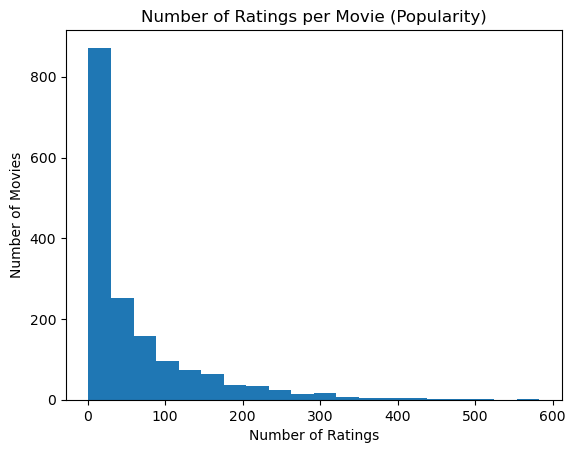

Most Rated Movies:
 movie title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: Rating, dtype: int64
Least Rated Movies:
 movie title
Á köldum klaka (Cold Fever) (1994)            1
Mille bolle blu (1993)                        1
Mat' i syn (1997)                             1
Marlene Dietrich: Shadow and Light (1996)     1
Man from Down Under, The (1943)               1
Mamma Roma (1962)                             1
Mad Dog Time (1996)                           1
Big Bang Theory, The (1994)                   1
MURDER and murder (1996)                      1
Coldblooded (1995)                            1
Name: Rating, dtype: int64


In [45]:
# Number of ratings per movie
ratings_per_movie = merged_dataset.groupby('movie title')['Rating'].count()

# Plot movie popularity distribution
ratings_per_movie.plot(kind='hist', bins=20, title='Number of Ratings per Movie (Popularity)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

# Top 10 most-rated movies
ratings_per_movie = merged_dataset.groupby('movie title')['Rating'].count()

top_rated_movies = ratings_per_movie.sort_values(ascending=False).head(10)
least_rated_movies = ratings_per_movie.sort_values(ascending=True).head(10)
print("Most Rated Movies:\n", top_rated_movies)
print("Least Rated Movies:\n", least_rated_movies)


The distribution is heavily skewed to the left, indicating that most items (movies) have a relatively low number of ratings.
Also a large number of movies have fewer than 50 ratings, with the count rapidly decreasing as the number of ratings per movie increases.

This possibly indicates a long tail of lesser-known or less popular movies. A few popular movies, however, receive a high volume of ratings, likely because they appeal to a broader audience.

 ### Rating Distribution per User
 
Similarly, we can calculate the distribution of ratings that each user gives. This shows whether individual users tend to give higher, lower, or balanced ratings.

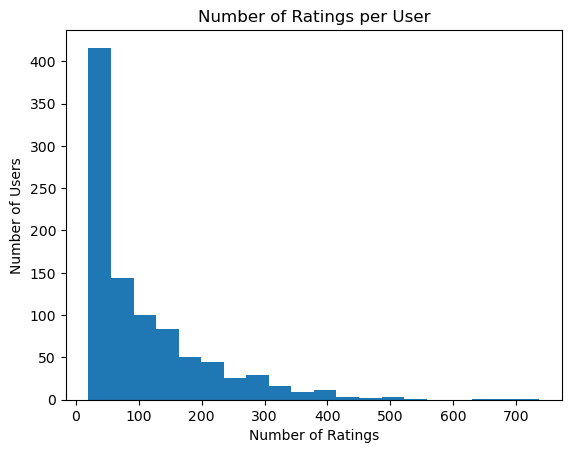

User id
405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
Name: Rating, dtype: int64


In [28]:
# Number of ratings per user
ratings_per_user = merged_dataset.groupby('User id')['Rating'].count()

# Plot distribution of ratings per user
ratings_per_user.plot(kind='hist', bins=20, title='Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

# Optional: Top 10 most active users
most_active_users = ratings_per_user.sort_values(ascending=False).head(10)
print(most_active_users)


The plot shows a left-skewed distribution, where most users have rated a small number of movies.
The majority of users have given fewer than 100 ratings.

The system might inadvertently favor movies rated by active users, as these movies are more likely to appear in the training data.


## 2- Distrubution of movies 

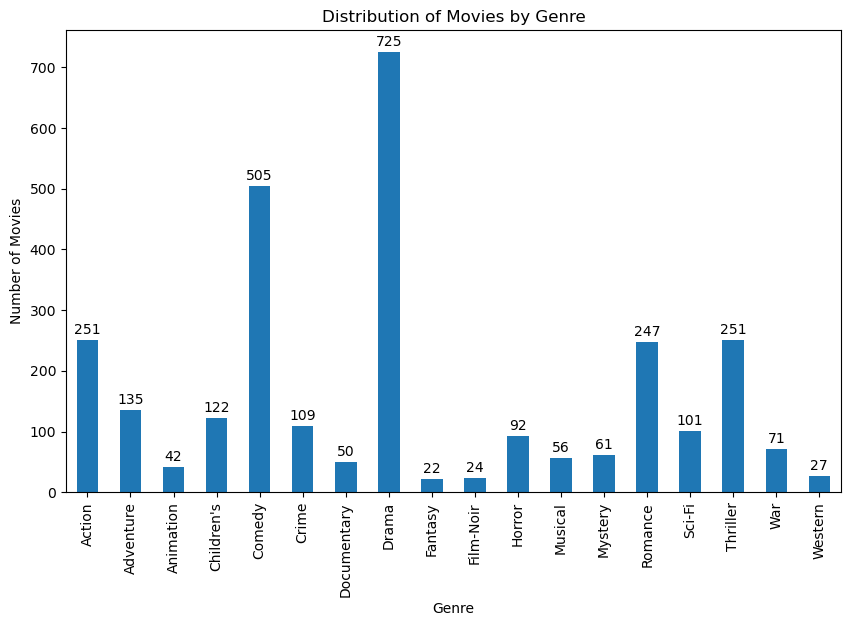

Movies per Genre:
 Action         251
Adventure      135
Animation       42
Children's     122
Comedy         505
Crime          109
Documentary     50
Drama          725
Fantasy         22
Film-Noir       24
Horror          92
Musical         56
Mystery         61
Romance        247
Sci-Fi         101
Thriller       251
War             71
Western         27
dtype: int64


In [46]:
# Summing up the genre columns (assuming genres are 0/1 binary indicators)
genre_counts = u_item.iloc[:, 6:].sum()

# Create the bar plot
ax = genre_counts.plot(kind='bar', title='Distribution of Movies by Genre', figsize=(10, 6))
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Annotate each bar with the total number of movies
for i, count in enumerate(genre_counts):
    ax.text(i, count + 5, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.show()

print("Movies per Genre:\n", genre_counts)


Drama is the most dominant genre in the dataset, while genres like Film-Noir, Fantasy, and Western are underrepresented, indicating potential biases in recommendations and opportunities to enhance diversity.

## 3- User data analysis 

To understand more about user's data , and bring some insights from it , some user data  visualization must be conducted.

In [42]:
u_user

,user id,age,gender,occupation,zip code,age_group
0,1,24,M,technician,85711,18-24
1,2,53,F,other,94043,50-59
2,3,23,M,writer,32067,18-24
3,4,24,M,technician,43537,18-24
4,5,33,F,other,15213,25-34
...,...,...,...,...,...,...
938,939,26,F,student,33319,25-34
939,940,32,M,administrator,02215,25-34
940,941,20,M,student,97229,18-24
941,942,48,F,librarian,78209,45-49


In [41]:
u_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   user id     943 non-null    int64   
 1   age         943 non-null    int64   
 2   gender      943 non-null    object  
 3   occupation  943 non-null    object  
 4   zip code    943 non-null    object  
 5   age_group   943 non-null    category
dtypes: category(1), int64(2), object(3)
memory usage: 38.2+ KB


we have  943 users , 

First , I tried to display the distribution of users by occupation :

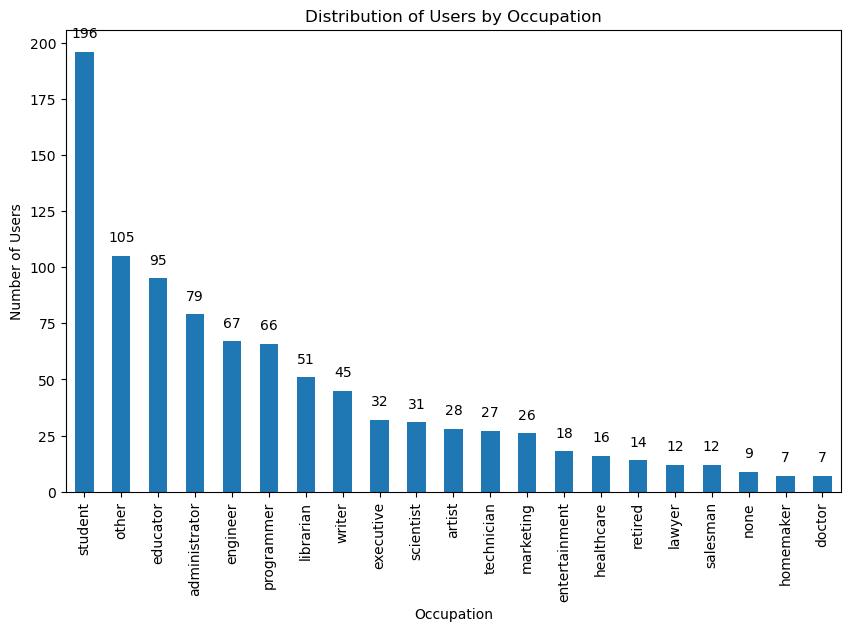

In [36]:
# Count users by occupation
occupation_counts = u_user['occupation'].value_counts()
# Create the bar plot
ax = occupation_counts.plot(kind='bar', title='Distribution of Users by Occupation',figsize=(10, 6))



# Plot distribution of users by occupation
plt.xlabel('Occupation')
plt.ylabel('Number of Users')
# Annotate each bar with the total number of movies
for i, count in enumerate(occupation_counts):
    ax.text(i, count + 5, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.show()
plt.show()



The dataset reflects a highly diverse user base, with students being the largest group, followed by educators and administrators, while certain occupations like doctors and homemakers have minimal representation.

Now let's see the distribution of users by gender

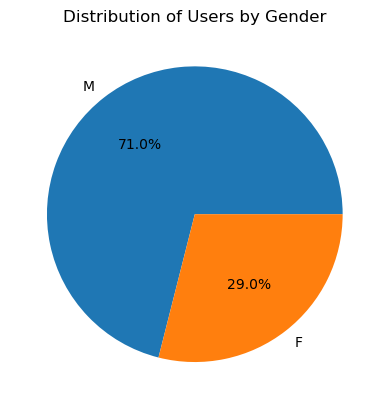

In [37]:
# Count users by gender
gender_counts = u_user['gender'].value_counts()

# Plot distribution of users by gender
gender_counts.plot(kind='pie', autopct='%1.1f%%', title='Distribution of Users by Gender')
plt.ylabel('')
plt.show()


The majoraty of users are male with a high percentage (71%), while female users represents only 29%

Another feature  is the age group of the users:

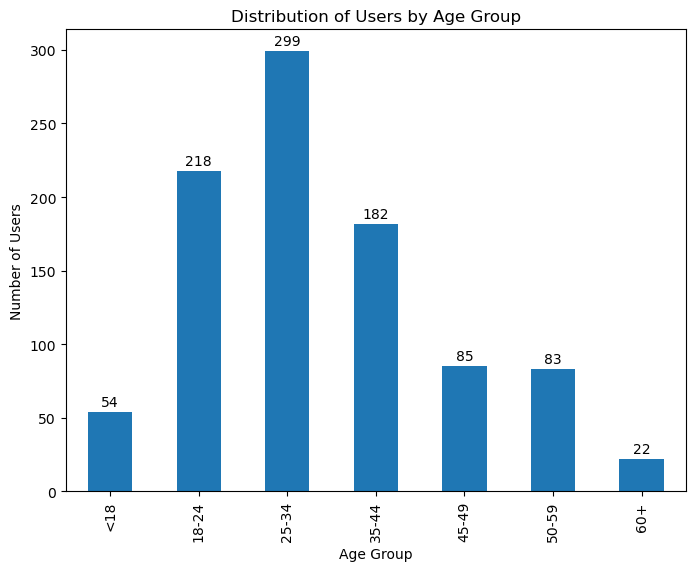

In [43]:
# Count the number of users in each age group
age_group_counts = u_user['age_group'].value_counts().sort_index()

# Plot the distribution of users by age group
ax = age_group_counts.plot(kind='bar', title='Distribution of Users by Age Group', figsize=(8, 6))
plt.xlabel('Age Group')
plt.ylabel('Number of Users')

# Annotate each bar with the number of users
for i, count in enumerate(age_group_counts):
    ax.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


The largest number of users fall within the 25-34 age group (299 users), making it the most represented demographic in the dataset.Since the 25-34 and 18-24 age groups dominate, the recommendation system may tend to prioritize preferences of younger users, 


### 4- Merging of tha data 

Let's see the distribution of rating per genres

In [47]:
# Merge u_data and movies_data on movie id to include genre information
merged_data = u_Data.merge(u_item, left_on='movie id', right_on='movie id')
merged_data


,User id,movie id,Rating,Timestamp,date,movie title,release date,video releasedate,IMDb URL,unknown,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,1997-12-04 15:55:49,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,1998-04-04 19:22:22,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,1997-11-07 07:18:36,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,1997-11-27 05:02:03,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,1998-02-02 05:33:16,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22 05:10:44,"First Wives Club, The (1996)",14-Sep-1996,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,879795543,1997-11-17 19:39:03,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,...,0,0,0,0,0,0,1,0,0,0
99997,276,1090,1,874795795,1997-09-20 22:49:55,Sliver (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,...,0,0,0,0,0,0,0,1,0,0
99998,13,225,2,882399156,1997-12-17 22:52:36,101 Dalmatians (1996),27-Nov-1996,NaN,http://us.imdb.com/M/title-exact?101%20Dalmati...,0,...,0,0,0,0,0,0,0,0,0,0


This first chart shows the average rating by genre for the movies in your dataset

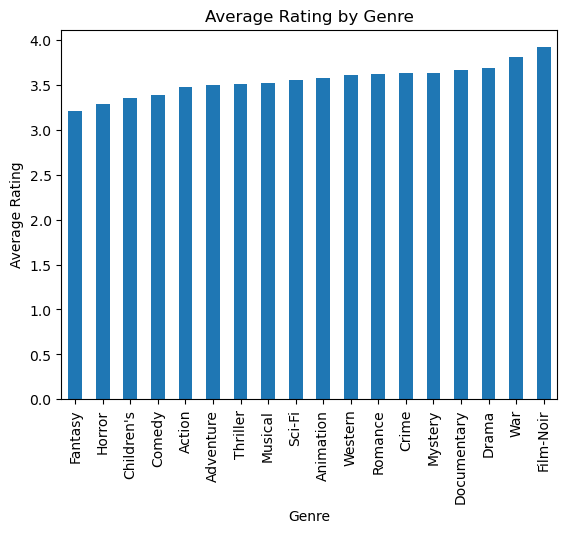

In [48]:

# Calculate average rating for each genre
genre_ratings = {}
for genre in genre_counts.index:
    genre_ratings[genre] = merged_data.loc[merged_data[genre] == 1, 'Rating'].mean()

# Plot average rating by genre
pd.Series(genre_ratings).sort_values().plot(kind='bar', title='Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()



The plot shows that most genres have average ratings close to 4, indicating generally positive user feedback across genres. Film-Noir, War, and Drama are the highest-rated genres, suggesting these genres are more consistently appreciated by users, while Fantasy has the lowest average rating, potentially reflecting a niche audience or variability in movie quality.

In [49]:
u_Data

,User id,movie id,Rating,Timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16
...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22 05:10:44
99996,716,204,5,879795543,1997-11-17 19:39:03
99997,276,1090,1,874795795,1997-09-20 22:49:55
99998,13,225,2,882399156,1997-12-17 22:52:36


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25572\1106927683.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratings_over_time = u_Data.set_index('date').resample('M')['Rating'].count()


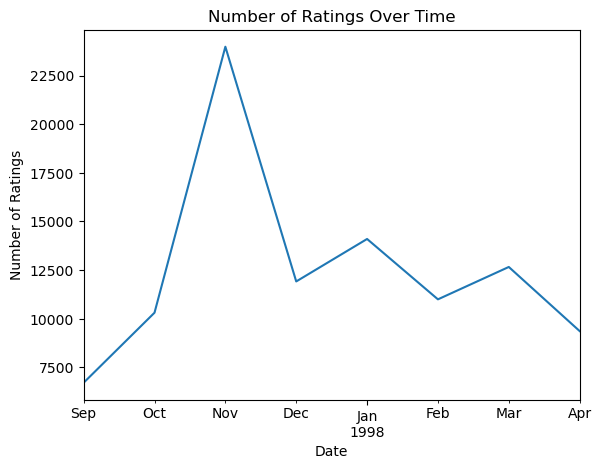

In [53]:

# Group by month and count the number of ratings
ratings_over_time = u_Data.set_index('date').resample('M')['Rating'].count()

# Plot ratings over time
ratings_over_time.plot(title='Number of Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()


The plot shows the **number of ratings over time**, with a significant spike in November 1997, indicating a peak in user activity during that period. After this peak, the number of ratings decreases but fluctuates moderately until March 1998, when there is a noticeable decline in activity. This suggests possible seasonal or campaign-driven activity influencing user engagement.

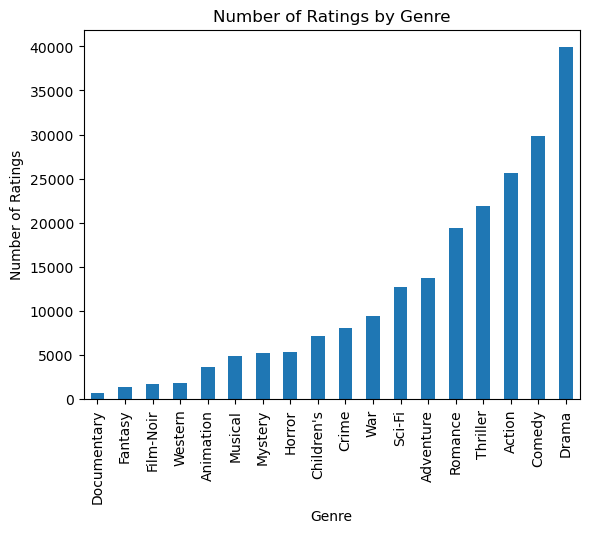

In [54]:
# Count ratings for each genre
genre_rating_counts = {}
for genre in genre_counts.index:
    genre_rating_counts[genre] = merged_data.loc[merged_data[genre] == 1, 'Rating'].count()

# Plot ratings count by genre
pd.Series(genre_rating_counts).sort_values().plot(kind='bar', title='Number of Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.show()


The plot shows the number of ratings received by each genre, with Drama being the most rated genre, followed by Comedy and Action, indicating their popularity among users. On the other hand, genres like Documentary, Fantasy, and Film-Noir have significantly fewer ratings, suggesting they are less commonly watched or rated by users in the dataset

In [ ]:
# Movies in both Action and Sci-Fi
action_sci_fi_ratings = merged_data.loc[(merged_data['Action'] == 1) & (merged_data['Sci-Fi'] == 1), 'Rating']
print("Average Rating for Action & Sci-Fi Movies:", action_sci_fi_ratings.mean())


Average Rating for Action & Sci-Fi Movies: 3.533132530120482


## Item based colloaborative filtering  (IBCF)

#### Preprocessing